## RealNVP

1. 복잡한 input 데이터 분포를 간단한 가우스 분포로 변환
2. 역변환 가능 + 야코비 행렬 쉽게 계산 가능


초승달 데이터셋으로 RealNVP구현해보자!

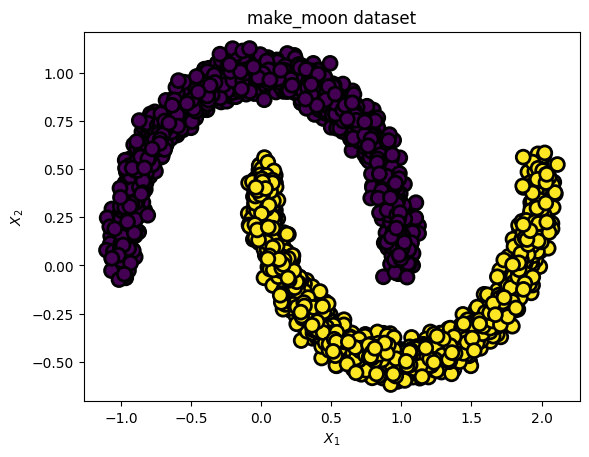

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-07 16:32:43.943549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-07 16:32:43.943640: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-07 16:32:43.992706: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-07 16:32:44.053645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-05-07 16:32:44.069707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [1]:
# datasets
from sklearn.datasets import make_moons
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 데이터셋 시각화
plt.title("make_moon dataset")
X, y = make_moons(n_samples=3000, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100,
            edgecolor="k", linewidth=2)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

# 초승달 데이터셋 normalizaion ->평균 0 표준 편차 1
X.astype('float32')
norm = layers.Normalization()
norm.adapt(X)
norm_data = norm(X)

In [8]:
'''coupling layer
입력의 각 원소에 대해 스케일 계수와 이동 계수를 만든다. scale + translation
'''

from tensorflow.keras import (
    models,
    metrics,
    regularizers,
    optimizers)


def Coupling(input_dim, coupling_dim, regularization):
    input_layer = layers.Input(shape = 2)

    s_layer_1 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(input_layer)
    s_layer_2 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        2, activation='tanh', kernel_regularizer = regularizers.l2(0.01)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(input_layer)
    t_layer_2 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        256, activation='relu', kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        2, activation='linear', kernel_regularizer = regularizers.l2(0.01)
    )(t_layer_4)
    
    return models.Model(inputs = input_layer, outputs = [s_layer_5, t_layer_5])



In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    models,
    metrics,
    regularizers,
    optimizers)

import tensorflow_probability as tfp

class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim= 2,
    coupling_layers= 6,
    coupling_dim= 256,
    regularization= 0.001,
)


In [11]:
# train RealNVP

model.compile(optimizer = optimizers.Adam(learning_rate = 0.0001))

history = model.fit(
    norm_data,
    batch_size = 256,
    epochs = 300
)

Epoch 1/300


2024-05-07 16:42:34.060154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 7s 280ms/step - loss: 2.4169
Epoch 2/300
12/12 [==============================] - 1s 87ms/step - loss: 2.3880
Epoch 3/300
12/12 [==============================] - 1s 61ms/step - loss: 2.3661
Epoch 4/300
12/12 [==============================] - 1s 62ms/step - loss: 2.3423
Epoch 5/300
12/12 [==============================] - 1s 58ms/step - loss: 2.3146
Epoch 6/300
12/12 [==============================] - 1s 52ms/step - loss: 2.2912
Epoch 7/300
12/12 [==============================] - 1s 53ms/step - loss: 2.2632
Epoch 8/300
12/12 [==============================] - 1s 55ms/step - loss: 2.2304
Epoch 9/300
12/12 [==============================] - 1s 53ms/step - loss: 2.2017
Epoch 10/300
12/12 [==============================] - 1s 54ms/step - loss: 2.1663
Epoch 11/300
12/12 [==============================] - 1s 53ms/step - loss: 2.1413
Epoch 12/300
12/12 [==============================] - 1s 55ms/step - loss: 2.1201
Epoch 13/300
12/12 [================

In [17]:
def display(num):
    # 데이터에서 잠재 공간까지.
    z, _ = model(norm_data)

    # 잠재 공간에서 데이터까지.
    samples = model.distribution.sample(num)
    x, _ = model.predict(samples, verbose=0)

    f, axes = plt.subplots(2, 2)
    f.set_size_inches(8, 5)

    axes[0, 0].scatter(
        norm_data[:, 0], norm_data[:, 1], color="r", s=1
    )
    axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
    axes[0, 0].set_xlim([-2, 2])
    axes[0, 0].set_ylim([-2, 2])
    axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
    axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
    axes[0, 1].set_xlim([-2, 2])
    axes[0, 1].set_ylim([-2, 2])
    axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
    axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
    axes[1, 0].set_xlim([-2, 2])
    axes[1, 0].set_ylim([-2, 2])
    axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
    axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
    axes[1, 1].set_xlim([-2, 2])
    axes[1, 1].set_ylim([-2, 2])

    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    plt.show()


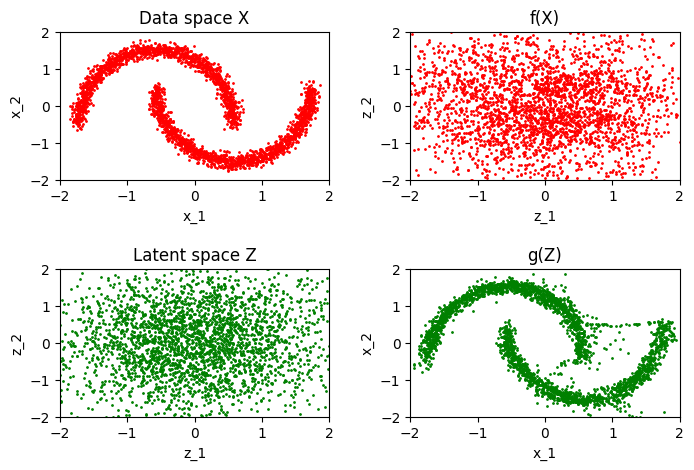

In [18]:
display(3000)